In [7]:
from PIL import Image
import numpy as np
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb
from PIL import Image
import cv2
from matplotlib import pyplot as plt

In [39]:
lines


['E:/SHI/YOLO_V3/model_data/images/drone_23.jpg 28,264,147,385,2\n',
 'E:/SHI/YOLO_V3/model_data/images/aeroplane_112.jpg 39,185,289,280,0\n',
 'E:/SHI/YOLO_V3/model_data/images/jet_321.jpg 126,80,227,332,4\n',
 'E:/SHI/YOLO_V3/model_data/images/drone_35.jpg 52,49,371,377,2\n',
 'E:/SHI/YOLO_V3/model_data/images/aeroplane_193.jpg 6,162,403,271,0\n',
 'E:/SHI/YOLO_V3/model_data/images/aeroplane_55.jpg 27,162,300,246,0\n',
 'E:/SHI/YOLO_V3/model_data/images/helicopter_344.jpg 202,136,373,201,3\n',
 'E:/SHI/YOLO_V3/model_data/images/birds_56.jpg 12,23,397,327,1\n',
 'E:/SHI/YOLO_V3/model_data/images/birds_285.jpg 112,69,347,381,1\n',
 'E:/SHI/YOLO_V3/model_data/images/helicopter_104.jpg 85,151,395,260,3 18,251,89,282,3\n',
 'E:/SHI/YOLO_V3/model_data/images/aeroplane_136.jpg 27,103,386,213,0\n',
 'E:/SHI/YOLO_V3/model_data/images/aeroplane_267.jpg 50,154,335,245,0\n',
 'E:/SHI/YOLO_V3/model_data/images/aeroplane_210.jpg 71,144,386,299,0\n',
 'E:/SHI/YOLO_V3/model_data/images/drone_326.jpg

In [36]:
def rand(a=0, b=1):
    return 0.50409383655*(b-a) + a

In [37]:
def get_random_data(annotation_line, input_shape, random=True, max_boxes=20, jitter=.3, hue=.1, sat=1.5, val=1.5, proc_img=True):
    '''random preprocessing for real-time data augmentation'''
    line = annotation_line.split()
    image = Image.open(line[0])
    iw, ih = image.size
    h, w = input_shape
    box = np.array([np.array(list(map(int,box.split(',')))) for box in line[1:]])

    if not random:
        # resize image
        scale = min(w/iw, h/ih)
        nw = int(iw*scale)
        nh = int(ih*scale)
        dx = (w-nw)//2
        dy = (h-nh)//2
        image_data=0
        if proc_img:
            image = image.resize((nw,nh), Image.BICUBIC)
            new_image = Image.new('RGB', (w,h), (128,128,128))
            new_image.paste(image, (dx, dy))
            image_data = np.array(new_image)/255.

        # correct boxes
        box_data = np.zeros((max_boxes,5))
        if len(box)>0:
            np.random.shuffle(box)
            if len(box)>max_boxes: box = box[:max_boxes]
            box[:, [0,2]] = box[:, [0,2]]*scale + dx
            box[:, [1,3]] = box[:, [1,3]]*scale + dy
            box_data[:len(box)] = box

        return image_data, box_data

    # resize image
    
    new_ar = w/h * rand(1-jitter,1+jitter)/rand(1-jitter,1+jitter)
    scale = rand(.25, 2)
    if new_ar < 1:
        nh = int(scale*h)
        nw = int(nh*new_ar)
    else:
        nw = int(scale*w)
        nh = int(nw/new_ar)
    image = image.resize((nw,nh), Image.BICUBIC)

    # place image
    dx = int(rand(0, w-nw))
    dy = int(rand(0, h-nh))
    new_image = Image.new('RGB', (w,h), (128,128,128))
    new_image.paste(image, (dx, dy))
    image = new_image

    # flip image or not
    flip = rand()<.5
    if flip: image = image.transpose(Image.FLIP_LEFT_RIGHT)

    # distort image
    hue = rand(-hue, hue)
    sat = rand(1, sat) if rand()<.5 else 1/rand(1, sat)
    val = rand(1, val) if rand()<.5 else 1/rand(1, val)
    x = rgb_to_hsv(np.array(image)/255.)
    x[..., 0] += hue
    x[..., 0][x[..., 0]>1] -= 1
    x[..., 0][x[..., 0]<0] += 1
    x[..., 1] *= sat
    x[..., 2] *= val
    x[x>1] = 1
    x[x<0] = 0
    image_data = hsv_to_rgb(x) # numpy array, 0 to 1

    # correct boxes
    box_data = np.zeros((max_boxes,5))
    if len(box)>0:
        np.random.shuffle(box)
        box[:, [0,2]] = box[:, [0,2]]*nw/iw + dx
        box[:, [1,3]] = box[:, [1,3]]*nh/ih + dy
        if flip: box[:, [0,2]] = w - box[:, [2,0]]
        box[:, 0:2][box[:, 0:2]<0] = 0
        box[:, 2][box[:, 2]>w] = w
        box[:, 3][box[:, 3]>h] = h
        box_w = box[:, 2] - box[:, 0]
        box_h = box[:, 3] - box[:, 1]
        box = box[np.logical_and(box_w>1, box_h>1)] # discard invalid box
        if len(box)>max_boxes: box = box[:max_boxes]
        box_data[:len(box)] = box

    return image_data, box_data

In [5]:
annotation_path='E:/SHI/YOLO_V3/model_data/image.txt'

with open(annotation_path) as f:
    lines = f.readlines()
np.random.shuffle(lines)

2017

[[[0.28502346 0.28502346 0.28502346]
  [0.28502346 0.28502346 0.28502346]
  [0.28815559 0.28815559 0.28815559]
  ...
  [0.36019448 0.35775433 0.34768646]
  [0.35706236 0.3546222  0.34455434]
  [0.35393023 0.35149007 0.34142221]]

 [[0.28502346 0.28502346 0.28502346]
  [0.28502346 0.28502346 0.28502346]
  [0.28502346 0.28502346 0.28502346]
  ...
  [0.36332661 0.36088645 0.35081859]
  [0.36019448 0.35775433 0.34768646]
  [0.35706236 0.3546222  0.34455434]]

 [[0.28502346 0.28502346 0.28502346]
  [0.28502346 0.28502346 0.28502346]
  [0.28502346 0.28502346 0.28502346]
  ...
  [0.36645873 0.36401858 0.35395071]
  [0.36332661 0.36088645 0.35081859]
  [0.36019448 0.35775433 0.34768646]]

 ...

 [[0.19419181 0.15451024 0.12414689]
  [0.20045606 0.16077449 0.13041114]
  [0.21298456 0.17081368 0.14043804]
  ...
  [0.21611669 0.16646558 0.13856696]
  [0.20358819 0.15640181 0.13354327]
  [0.17539905 0.13071428 0.10535413]]

 [[0.16287055 0.11817349 0.09532723]
  [0.16287055 0.12067509 0.09532723]


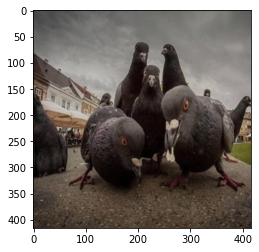

E:/SHI/YOLO_V3/model_data/images/birds_403.jpg 11,157,83,306,1 105,168,214,352,1 235,143,363,351,1 208,121,243,295,1 178,68,228,215,1 237,77,304,140,1 366,159,405,270,1


In [47]:
lines=lines[:100]
line="E:/SHI/YOLO_V3/model_data/images/birds_403.jpg 11,157,83,306,1 105,168,214,352,1 235,143,363,351,1 208,121,243,295,1 178,68,228,215,1 237,77,304,140,1 366,159,405,270,1"
input_shape=(416,416)
get_random_data(line, input_shape)
print(line)